In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Set visualization styles and configurations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Define file paths
DATA_DIR = '../data/'
ARTIFACT_DIR = '../artifacts/'

In [3]:
# Load the datasets used for training the committee
try:
    train_df = pd.read_csv(f'{DATA_DIR}/unified_train.csv')
    validation_df = pd.read_csv(f'{DATA_DIR}/unified_validation.csv')
    
    # Combine them to get the full analysis set
    analysis_df = pd.concat([train_df, validation_df], ignore_index=True)
    
    # Also load the final OOF predictions for later use
    oof_df = pd.read_csv(f'{ARTIFACT_DIR}/oof_predictions.csv')
    y_true_labels = oof_df['target'] # The true labels (0, 1, 2)

    print("--- Data loaded successfully ---")
    print(f"Shape of the analysis dataset: {analysis_df.shape}")

except FileNotFoundError as e:
    print(f"Error: Could not find necessary data files.")
    print(e)
    print("Please ensure you have run 'train_base_models.py' successfully.")

--- Data loaded successfully ---
Shape of the analysis dataset: (18040, 16)


In [4]:
print("--- Data Info ---")
analysis_df.info()

print("\n\n--- Statistical Summary ---")
# .T transposes the output to make it easier to read
analysis_df.describe().T

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   period            18040 non-null  float64
 1   duration          18040 non-null  float64
 2   depth             18040 non-null  float64
 3   planet_radius     18040 non-null  float64
 4   equilibrium_temp  18040 non-null  float64
 5   insolation_flux   18040 non-null  float64
 6   stellar_temp      18040 non-null  float64
 7   stellar_gravity   18040 non-null  float64
 8   stellar_radius    18040 non-null  float64
 9   ra                18040 non-null  float64
 10  dec               18040 non-null  float64
 11  fpflag_nt         18040 non-null  int64  
 12  fpflag_ss         18040 non-null  int64  
 13  fpflag_co         18040 non-null  int64  
 14  fpflag_ec         18040 non-null  int64  
 15  disposition       18040 non-null  int64  
dtypes: float64(11), int64(

,count,mean,std,min,25%,50%,75%,max
period,18040.0,49.335101,1157.390838,0.152076,2.645365,5.850824,16.121066,1.299958e+05
duration,18040.0,4.217534,4.487510,0.052000,2.364995,3.215430,4.370075,9.001000e+01
depth,18040.0,13767.166097,56891.943014,0.000000,460.650000,1230.400000,5175.269976,1.541400e+06
planet_radius,18040.0,53.839595,2193.572167,0.080000,2.030000,3.940000,12.749475,2.003460e+05
equilibrium_temp,18040.0,1134.000380,711.960318,25.000000,722.000000,1008.000000,1364.000000,1.466700e+04
insolation_flux,18040.0,4439.443807,112912.920703,0.000000,59.455603,222.388000,715.715425,1.094755e+07
stellar_temp,18040.0,5663.664715,1169.350739,2520.000000,5231.750000,5720.000000,6093.000000,5.000000e+04
stellar_gravity,18040.0,4.335173,0.356306,0.100000,4.224000,4.412000,4.520000,5.960650e+00
stellar_radius,18040.0,1.492519,4.337860,0.109000,0.824000,1.027385,1.450000,2.299080e+02
ra,18040.0,230.018093,93.349199,0.084680,148.387501,286.535956,294.710285,3.599412e+02


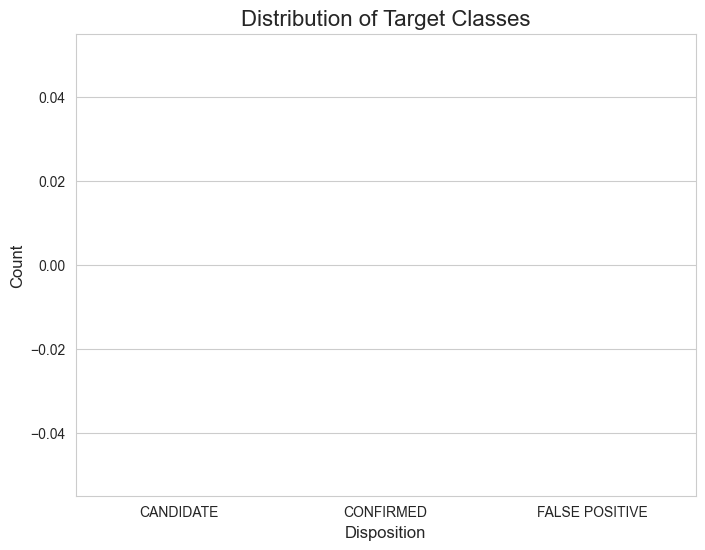


--- Value Counts ---
disposition
1    7210
0    5477
2    5353
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='disposition', data=analysis_df, order=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'])
plt.title('Distribution of Target Classes', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Disposition', fontsize=12)
plt.show()

print("\n--- Value Counts ---")
print(analysis_df['disposition'].value_counts())

--- Visualizing Key Feature Distributions ---


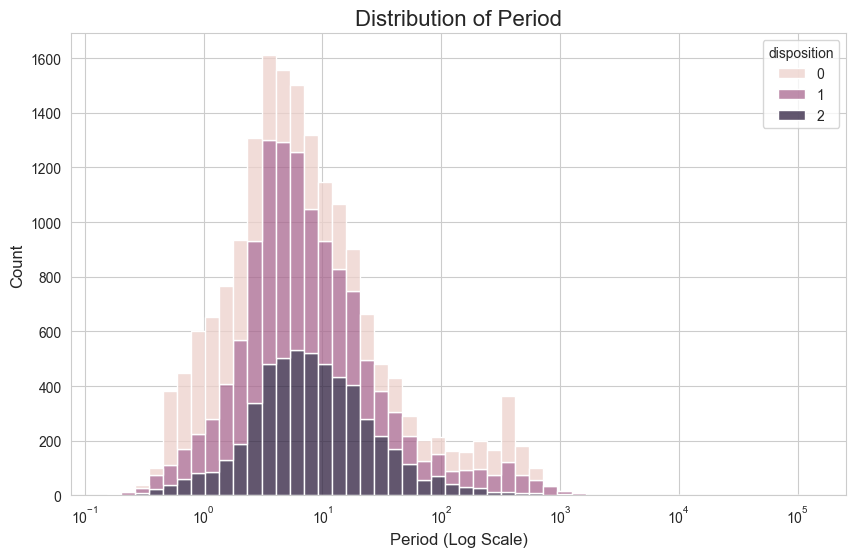

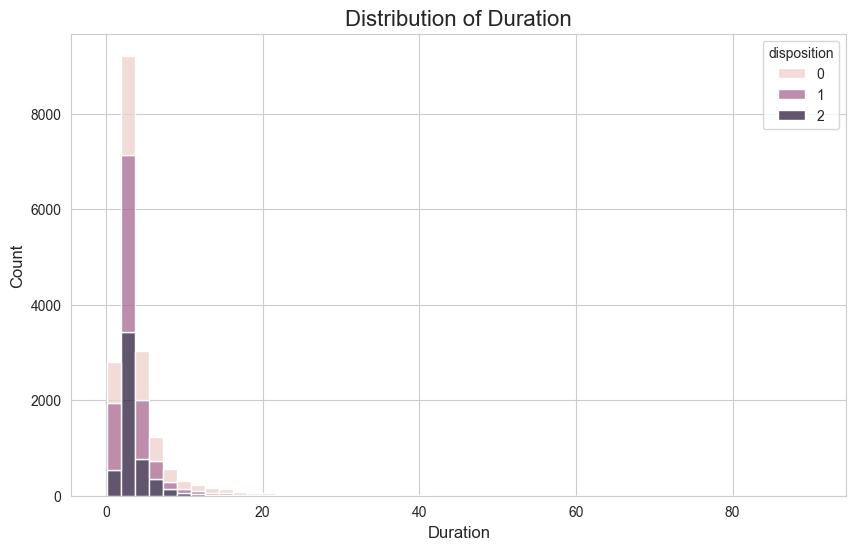

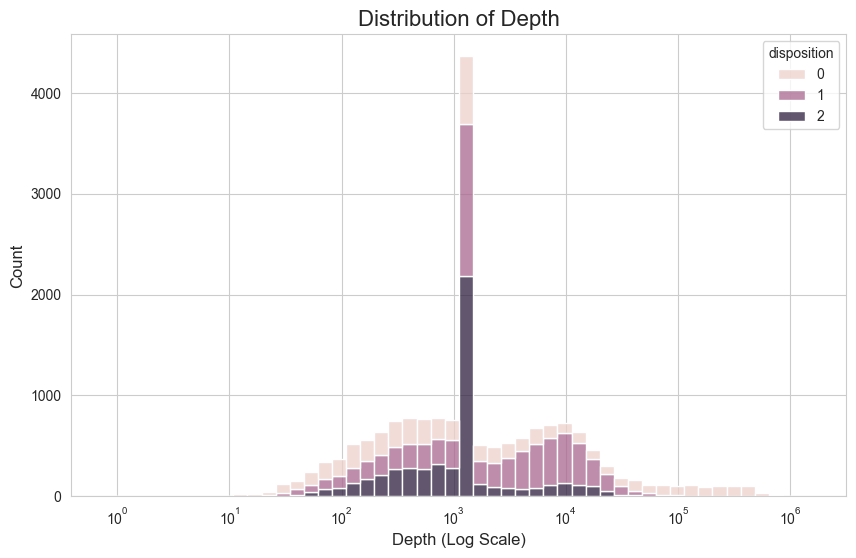

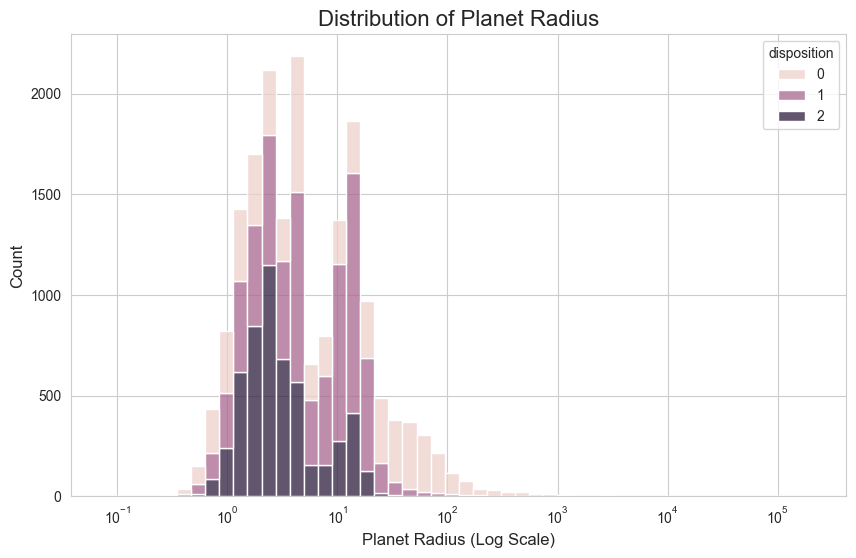

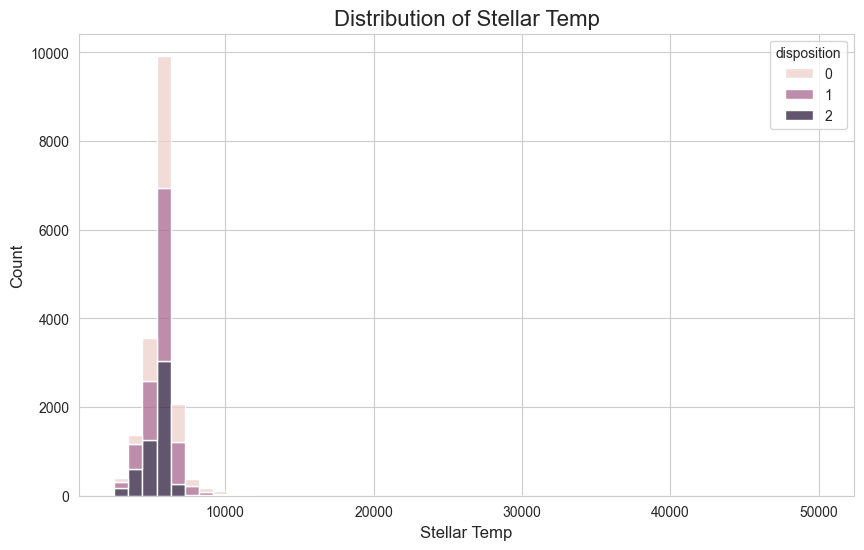

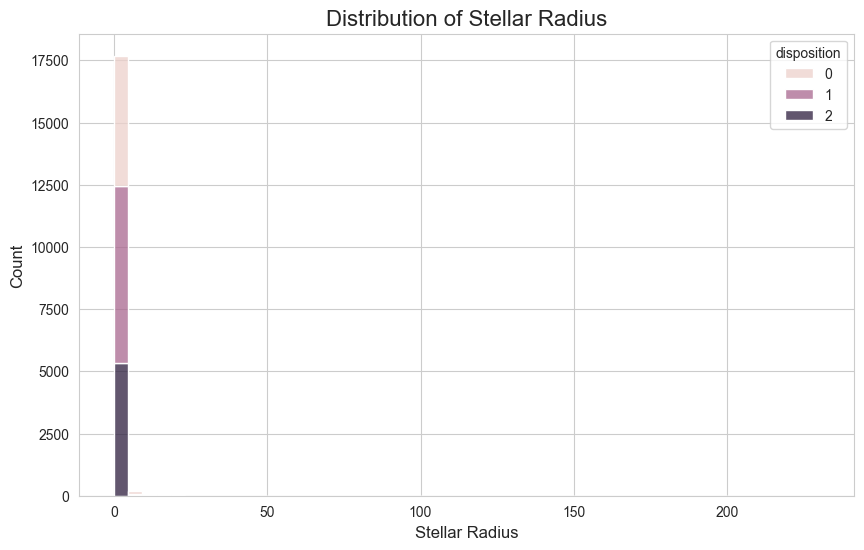

In [6]:
key_features = [
    'period', 
    'duration', 
    'depth', 
    'planet_radius', 
    'stellar_temp', 
    'stellar_radius'
]

print("--- Visualizing Key Feature Distributions ---")
for feature in key_features:
    plt.figure(figsize=(10, 6))
    # Use log_scale=True for heavily skewed features to see their structure
    use_log_scale = feature in ['period', 'depth', 'planet_radius', 'insolation_flux']
    
    sns.histplot(data=analysis_df, x=feature, hue='disposition', 
                 multiple='stack', bins=50, log_scale=use_log_scale)
    
    plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
    plt.xlabel(f'{feature.replace("_", " ").title()}{" (Log Scale)" if use_log_scale else ""}', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

--- Generating Diagnostic Scatter Plots ---


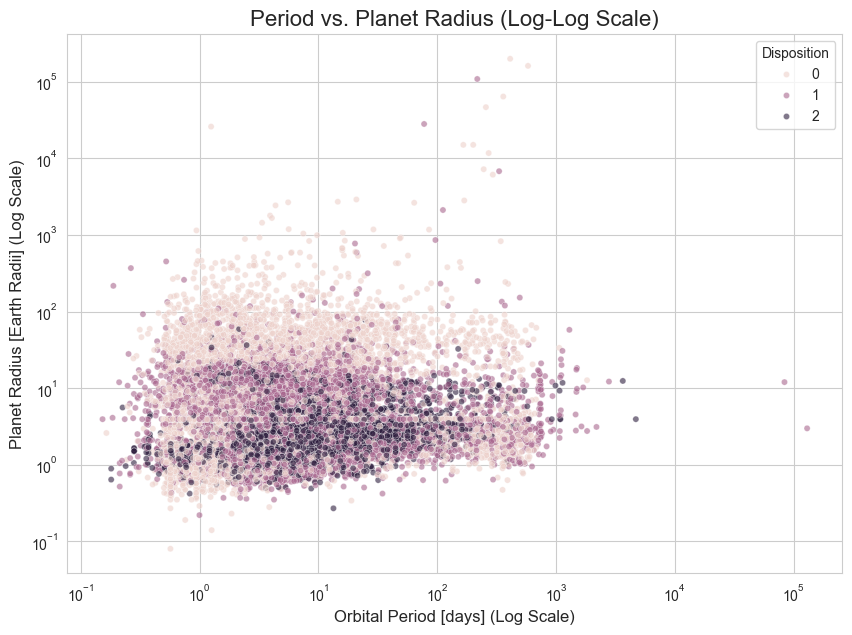

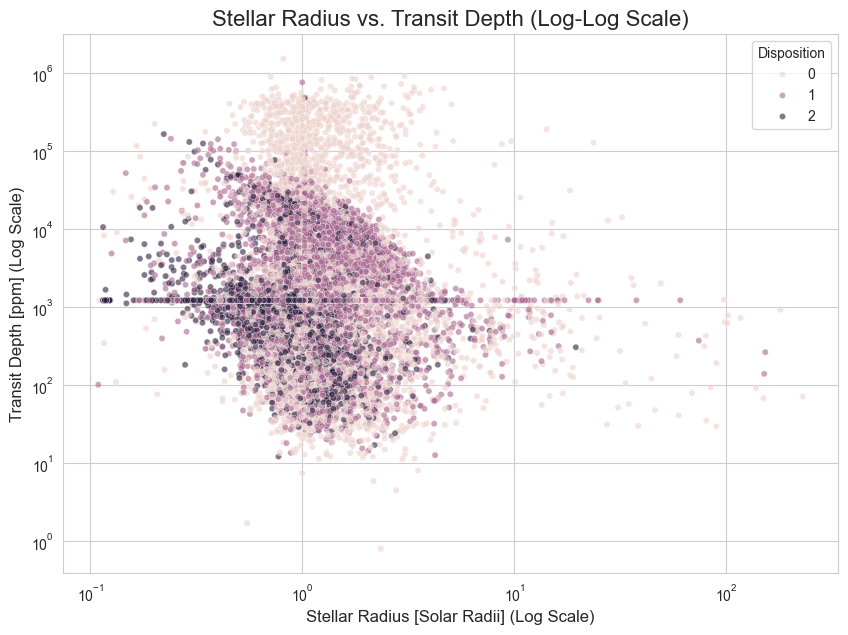

In [7]:
print("--- Generating Diagnostic Scatter Plots ---")

# Plot 1: Period vs. Planet Radius (a classic exoplanet discovery plot)
plt.figure(figsize=(10, 7))
ax1 = sns.scatterplot(data=analysis_df, x='period', y='planet_radius', hue='disposition', alpha=0.6, s=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Period vs. Planet Radius (Log-Log Scale)', fontsize=16)
ax1.set_xlabel('Orbital Period [days] (Log Scale)', fontsize=12)
ax1.set_ylabel('Planet Radius [Earth Radii] (Log Scale)', fontsize=12)
plt.legend(title='Disposition')
plt.show()

# Plot 2: Stellar Radius vs. Transit Depth
plt.figure(figsize=(10, 7))
ax2 = sns.scatterplot(data=analysis_df, x='stellar_radius', y='depth', hue='disposition', alpha=0.6, s=20)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Stellar Radius vs. Transit Depth (Log-Log Scale)', fontsize=16)
ax2.set_xlabel('Stellar Radius [Solar Radii] (Log Scale)', fontsize=12)
ax2.set_ylabel('Transit Depth [ppm] (Log Scale)', fontsize=12)
plt.legend(title='Disposition')
plt.show()

--- Loaded model for analysis ---


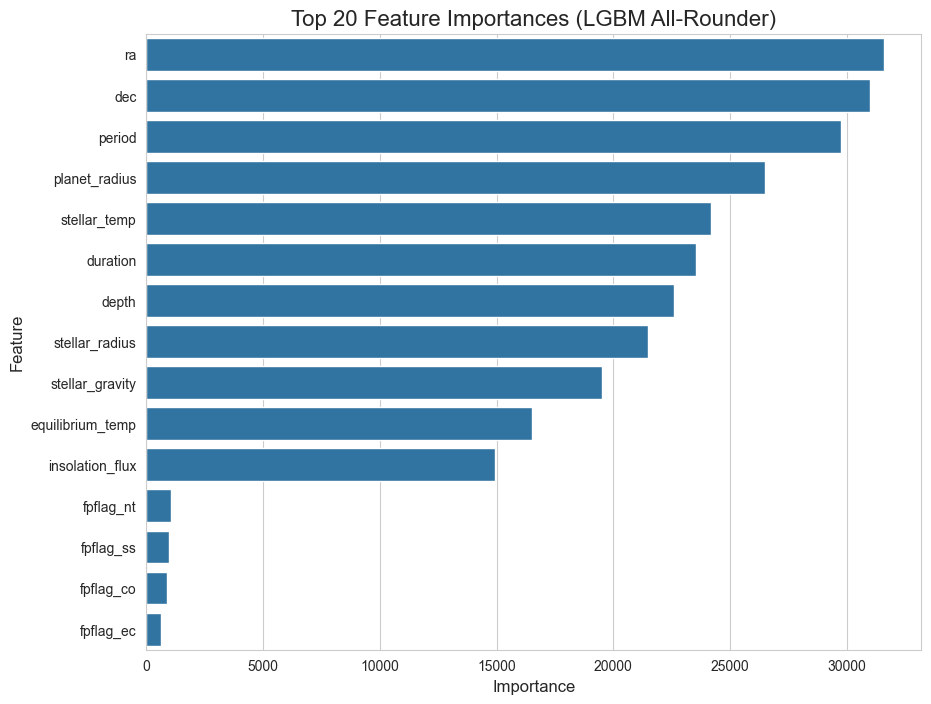

In [8]:
try:
    committee_of_experts = joblib.load(f'{ARTIFACT_DIR}/committee_of_experts.pkl')
    # Let's analyze the 'all-rounder' model
    model_to_analyze = committee_of_experts['lgbm_all_rounder']
    
    print("--- Loaded model for analysis ---")
    
    # Create a DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'feature': model_to_analyze.feature_name_,
        'importance': model_to_analyze.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot the top 20 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Feature Importances (LGBM All-Rounder)', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

except FileNotFoundError:
    print("Could not find 'committee_of_experts.pkl'. Please run 'train_base_models.py'.")

--- Setting up SHAP explainer ---

--- SHAP Summary Plot ---


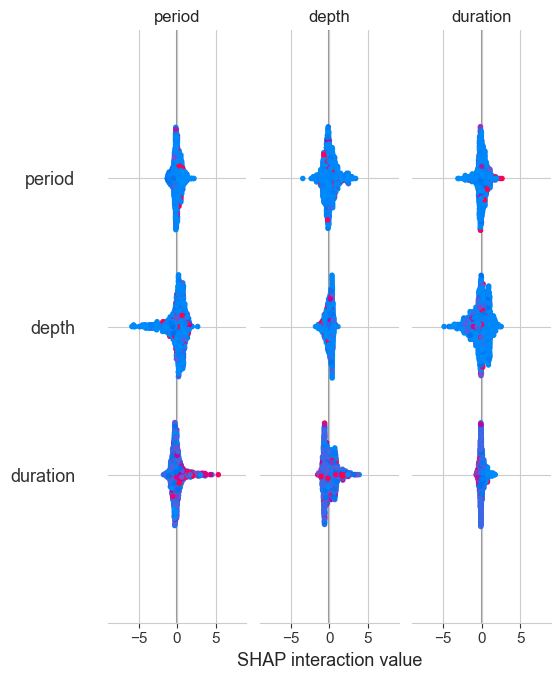

In [9]:
try:
    import shap
    print("--- Setting up SHAP explainer ---")
    
    # SHAP can be slow, so we'll use a representative sample of the data for the summary plot
    X_sample = analysis_df.drop(columns=['disposition']).sample(1000, random_state=42)
    
    # Create the explainer and calculate SHAP values
    explainer = shap.TreeExplainer(model_to_analyze)
    shap_values = explainer.shap_values(X_sample)
    
    # Generate the summary plot
    print("\n--- SHAP Summary Plot ---")
    DESCRIPTIVE_CLASS_NAMES = ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']
    shap.summary_plot(shap_values, X_sample, class_names=DESCRIPTIVE_CLASS_NAMES)
    
except ImportError:
    print("SHAP library not found. Please install it by running: pip install shap")
except Exception as e:
    print(f"An error occurred during SHAP analysis: {e}")

In [11]:
import pandas as pd

DATA_DIR = '../data/'

files_to_check = ['unified_train.csv', 'unified_validation.csv', 'unified_test.csv']
flag_columns = ['fpflag_nt', 'fpflag_ss', 'fpflag_co', 'fpflag_ec']

for filename in files_to_check:
    print(f"\n--- Verifying file: {filename} ---")
    try:
        df = pd.read_csv(f'{DATA_DIR}/{filename}')
        
        for col in flag_columns:
            if col in df.columns:
                print(f"Value counts for column '{col}':")
                print(df[col].value_counts())
                print("-" * 20)
            else:
                print(f"!!! Column '{col}' NOT FOUND in {filename} !!!")
    except FileNotFoundError:
        print(f"!!! File {filename} not found !!!")


--- Verifying file: unified_train.csv ---
Value counts for column 'fpflag_nt':
fpflag_nt
0    13788
1     1068
Name: count, dtype: int64
--------------------
Value counts for column 'fpflag_ss':
fpflag_ss
0    13314
1     1542
Name: count, dtype: int64
--------------------
Value counts for column 'fpflag_co':
fpflag_co
0    13531
1     1325
Name: count, dtype: int64
--------------------
Value counts for column 'fpflag_ec':
fpflag_ec
0    14069
1      787
Name: count, dtype: int64
--------------------

--- Verifying file: unified_validation.csv ---
Value counts for column 'fpflag_nt':
fpflag_nt
0      2963
1       220
465       1
Name: count, dtype: int64
--------------------
Value counts for column 'fpflag_ss':
fpflag_ss
0    2845
1     339
Name: count, dtype: int64
--------------------
Value counts for column 'fpflag_co':
fpflag_co
0    2919
1     265
Name: count, dtype: int64
--------------------
Value counts for column 'fpflag_ec':
fpflag_ec
0    3007
1     177
Name: count, dtype: 

In [12]:
# In your Jupyter Notebook

print("--- Data types of the combined analysis dataframe ---")
print(analysis_df.info())

--- Data types of the combined analysis dataframe ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   period            18040 non-null  float64
 1   duration          18040 non-null  float64
 2   depth             18040 non-null  float64
 3   planet_radius     18040 non-null  float64
 4   equilibrium_temp  18040 non-null  float64
 5   insolation_flux   18040 non-null  float64
 6   stellar_temp      18040 non-null  float64
 7   stellar_gravity   18040 non-null  float64
 8   stellar_radius    18040 non-null  float64
 9   ra                18040 non-null  float64
 10  dec               18040 non-null  float64
 11  fpflag_nt         18040 non-null  int64  
 12  fpflag_ss         18040 non-null  int64  
 13  fpflag_co         18040 non-null  int64  
 14  fpflag_ec         18040 non-null  int64  
 15  disposition       18040 non-null 